In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten

from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Check training will be done on GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    

Default GPU Device: /device:GPU:0


In [3]:
# Retrieve MNIST dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Ensure data is correct shape
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


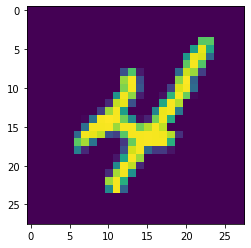

In [5]:
# Print Dataset Image
plt.imshow(x_train[9])

In [6]:
# Print Classes Present
print(set(y_train))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
# Adding Channels dimension
x_train = x_train[..., tf.newaxis].astype("float32") / 255
x_test = x_test[..., tf.newaxis].astype("float32") / 255


In [8]:
# Batching data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(16)


In [9]:
# Creating model subclass
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.dense1 = Dense(128, activation='relu')
    self.dense2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.dense1(x)
    return self.dense2(x)

# Create an instance of the model
model = MyModel()


In [10]:
# Choosing loss and optimiser
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [11]:
# Training metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [12]:
# Training the model
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


In [13]:
# Testing the model
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [14]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )


Epoch 1, Loss: 0.126772940158844, Accuracy: 96.13333129882812, Test Loss: 0.05416492745280266, Test Accuracy: 98.13999938964844
Epoch 2, Loss: 0.04123436287045479, Accuracy: 98.71333312988281, Test Loss: 0.05262459069490433, Test Accuracy: 98.33999633789062
Epoch 3, Loss: 0.019637051969766617, Accuracy: 99.40499877929688, Test Loss: 0.0526658371090889, Test Accuracy: 98.45999908447266
Epoch 4, Loss: 0.011735953390598297, Accuracy: 99.60832977294922, Test Loss: 0.07977193593978882, Test Accuracy: 98.00999450683594
Epoch 5, Loss: 0.008789132349193096, Accuracy: 99.69833374023438, Test Loss: 0.07477471232414246, Test Accuracy: 98.18000030517578


In [17]:
# Save the model
# model.save_weights('CNN_weights/CNN_Digit_Recog_Model')

In [ ]:
# # Re-Loading model
# validate_model = tf.keras.models.load_model('CNN_Digit_Recog_Model.h5')

# # Show the model architecture
# validate_model.summary()
